## 1. Краткая вводная:

В даннной работе мы имеем набор данных, содержащий информацию о поездках на жёлтом такси в Нью-Йорке за 2016 год. Этот набор уже разбит на тренировочный и тестовый и представлен в разных файлах. Также мы имеем 3 датасета, взятых из сторонних источников: 
  * Датасет с данными о праздниках
  * Датасет с данными о погоде
  * Датасет с данными о расстояниях поездок

Мы будем использовать их для создания новых признаков.

## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет. 


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Прочитаем наш файл с исходными данными:

In [112]:
taxi_df = pd.read_csv("data/train.zip", compression='zip')
print('Train data shape: {}'.format(taxi_df.shape))
taxi_df.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Итак, у нас есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок. 

Мы условно разделили признаки нескольких групп:

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу. 


Посмотрим на временные рамки, в которых мы работаем с данными.

Переведем признак pickup_datetime в тип данных datetime с форматом год-месяц-день час и определим временные рамки (без учета времени), за которые представлены данные:

In [113]:
taxi_df['pickup_datetime'] = pd.to_datetime(taxi_df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
print(taxi_df['pickup_datetime'].min())
print(taxi_df['pickup_datetime'].max())

2016-01-01 00:00:17
2016-06-30 23:59:39


Посмотрим, есть ли пропуски:

In [5]:
taxi_df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Посмотрим на статистические характеристики некоторых признаков:

  * Как распределены поездки между таксопарками?
  * Каково распределение пассажиров в поездках?
  * Чему равна средняя и медианная длительность поездки?
  * Чему равно минимальное и максимальное время поездки (в секундах)?

In [6]:
print(f'Распределение долей поездок по таксопаркам: \n\n{taxi_df.vendor_id.value_counts(normalize=True)}\n')
print(f'Распределение кол-ва пассажиров по поездкам: \n\n{taxi_df.passenger_count.value_counts()}\n')
print(f'Средняя длительность поездки: {np.round(taxi_df.trip_duration.mean())}') 
print(f'Медианная длительность поездки: {np.round(taxi_df.trip_duration.median())}\n')
print(f'Минимальное время поездки: {taxi_df.trip_duration.min()}')
print(f'Максимальное время поездки: {taxi_df.trip_duration.max()}')

Распределение долей поездок по таксопаркам: 

vendor_id
2    0.53495
1    0.46505
Name: proportion, dtype: float64

Распределение кол-ва пассажиров по поездкам: 

passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: count, dtype: int64

Средняя длительность поездки: 959.0
Медианная длительность поездки: 662.0

Минимальное время поездки: 1
Максимальное время поездки: 3526282


На данном этапе уже видно, что есть выбросы в данных, займемся ими позже.
А сейчас приступим к расширению исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками. 


Напишем функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - порядковый номер дня недели (число), в который был включен счетчик.

In [114]:
def add_datetime_features(df):
    df['pickup_date'] = pd.to_datetime(df['pickup_datetime']).dt.date
    df['pickup_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['pickup_day_of_week'] = pd.to_datetime(df['pickup_datetime']).dt.day_of_week
    return df

taxi_df = add_datetime_features(taxi_df)


Напишем функцию add_holiday_features(), которая принимает на вход две таблицы: 
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет). Применим ее к нашему датасету.


In [115]:
# Загрузим датасет с праздниками
holiday_df = pd.read_csv('data/holiday_data.csv', sep=';')

# Напишем функцию
def add_holiday_features(main_df, holiday_df):
    # Приведем столбцы с датами в формат datetime
    holiday_df['date'] = pd.to_datetime(holiday_df['date']) 
    main_df['pickup_date'] = pd.to_datetime(main_df['pickup_date']) 
    # Соединим датафреймы и заполним пропуски нулями
    main_df = main_df.merge(holiday_df, how='left', left_on='pickup_date', right_on='date')
    main_df = main_df.fillna(0)
    # Создадим новый столбец
    main_df['pickup_holiday'] = main_df['holiday'].apply(lambda x: 0 if x == 0 else 1)
    # Удалим ненужные столбцы
    main_df = main_df.drop(['day', 'date', 'holiday'], axis=1)
    # Вернем результат
    return main_df

# Применим функцию к нашему датафрейму
taxi_df = add_holiday_features(taxi_df, holiday_df)

Реализуем функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

In [116]:
# Загрузим датасет с данными по поездкам
osrm_df = pd.read_csv('data/osrm_data_train.zip', compression='zip')

def add_orsm_features(df, osrm_df):
    # Выделим нужные нам столбцы
    osrm_df = osrm_df[['id', 'total_distance', 'total_travel_time', 'number_of_steps']]
    # Соединим датафреймы
    df = df.merge(osrm_df, how='left', on='id')
    # Вернем результат объединения
    return df

taxi_df = add_orsm_features(taxi_df, osrm_df)

Зная широту и долготу начальной и конечной точек маршрута, можно вычислить географическое расстояние между точками на сфере по формуле Хаверсина, а также узнать направление движения автомобиля по формуле угла Пеленга.

Реализуем 2 функции:
  * get_haversine_distance
  * get_angle_direction

они обе будут принимать на вход широту и долготу начальной и конечной точек маршрута, первая будет выдавать географическое расстояние, а вторая направление.

In [117]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # Переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # Радиус земли в километрах
    EARTH_RADIUS = 6371 
    # Считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # Переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # Считаем угол направления движения alpha по формуле угла Пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

Напишем функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

In [118]:
def add_geographical_features(df):
    # Присвоим переменным значения широты и долготы
    lat1, lng1 = df['pickup_latitude'], df['pickup_longitude']
    lat2, lng2 = df['dropoff_latitude'], df['dropoff_longitude']
    # Применим ранее написанные функции
    df['haversine_distance'] = get_haversine_distance(lat1, lng1, lat2, lng2)
    df['direction'] = get_angle_direction(lat1, lng1, lat2, lng2)
    return df

# Применим функцию к нашему датасету
taxi_df = add_geographical_features(taxi_df)

Реализуем функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция будет возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

In [119]:
# Импортируем модуль для кластеризации
from sklearn import cluster

# Cоздаем обучающую выборку из географических координат всех точек
coords = np.hstack((taxi_df[['pickup_latitude', 'pickup_longitude']],
                    taxi_df[['dropoff_latitude', 'dropoff_longitude']]))

# Oбучаем алгоритм кластеризации
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

# Напишем функцию
def add_cluster_features(df, estimator):
    # Определим матрицу признаков
    coords = np.hstack((df[['pickup_latitude', 'pickup_longitude']],
                        df[['dropoff_latitude', 'dropoff_longitude']]))
    # Создадим столбец, в который запишем предсказания модели
    df['geo_cluster'] = estimator.predict(coords)
    return df

# Применим функцию к нашему датасету.
taxi_df = add_cluster_features(taxi_df, kmeans)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Реализуем функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

In [120]:
# Загрузим данные 
weather_data = pd.read_csv('data/weather_data.zip', compression='zip')

# Выделим нужные нам данные
weather_data = weather_data[(weather_data['time'] >= '2016-01-01') & (weather_data['time'] < '2016-07-01')]
weather_data = weather_data[['temperature', 'visibility', 'wind speed', 
                             'precip', 'events', 'date', 'hour']]
# Приведем столбец даты к нужному формату
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Напишем функцию
def add_weather_features(df, weather_data):
    # Объединим датасеты
    df = df.merge(weather_data, 
                  how='left', 
                  left_on=['pickup_date', 'pickup_hour'],
                  right_on=['date', 'hour']
                  )
    # Удалим столбцы, которые дублируют информацию
    df = df.drop(['date', 'hour'], axis=1)
    return df

# Применим функцию
taxi_df = add_weather_features(taxi_df, weather_data)

В результате добавления новой информации у нас появились пропущенные значения в данных и нам следует подчистить их.

Реализуем функцию fill_null_weather_data(), которая принимает на вход таблицу с данными о поездках и будет заполнять пропущенные значения в столбцах следующим образом:

  * Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполним медианным значением в зависимости от даты начала поездки.
  * Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполним медианным значением по столбцам.
  * Пропуски в столбце events заполним строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

In [121]:
def fill_null_weather_data(df):
    for col in ['temperature', 'visibility', 'wind speed', 'precip']:
        df[col] = df[col].fillna(df.groupby('pickup_date')[col].transform('median'))
    for col in ['total_distance', 'total_travel_time', 'number_of_steps']:
        df[col] = df[col].fillna(df[col].median())
    df['events'] = df['events'].fillna('None')
    return df
    
taxi_df = fill_null_weather_data(taxi_df)

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки. 

Проще всего найти слишком продолжительные поездки. Условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа. 

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды. 
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути, сделаем это и отобразим на графике:

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


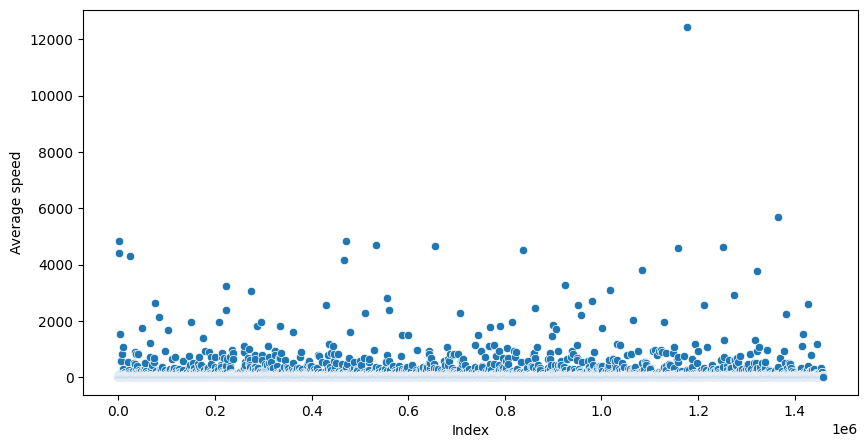

In [122]:
avg_speed = taxi_df['total_distance'] / taxi_df['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость превышает все разумные пределы. Даже есть такая, средняя скорость которой составляла более 12000 км/ч! 

Условимся, что предельная средняя скорость, которую могут развивать таксисты будет 100 км/ч. 

Таким образом, мы можем удалить поездки со скоростью выше 100 км.ч и поездки длительностью более 24 часов

In [124]:
taxi_df = taxi_df[taxi_df['trip_duration'] <= 86400]
taxi_df = taxi_df[taxi_df['total_distance'] / taxi_df['trip_duration'] * 3.6 <= 100]

## 3. Разведывательный анализ данных (EDA)

Начнем с целевого признака. Основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.

In [125]:
taxi_df['trip_duration_log'] = np.log(taxi_df['trip_duration']+1)

Приступим к визуализации. Для начала посмотрим на распределение целевого признака. Построим гистограмму и коробчатую диаграмму и проверим распределение на нормальность:

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Local\Temp\ipykernel_3384\4245455819.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-G

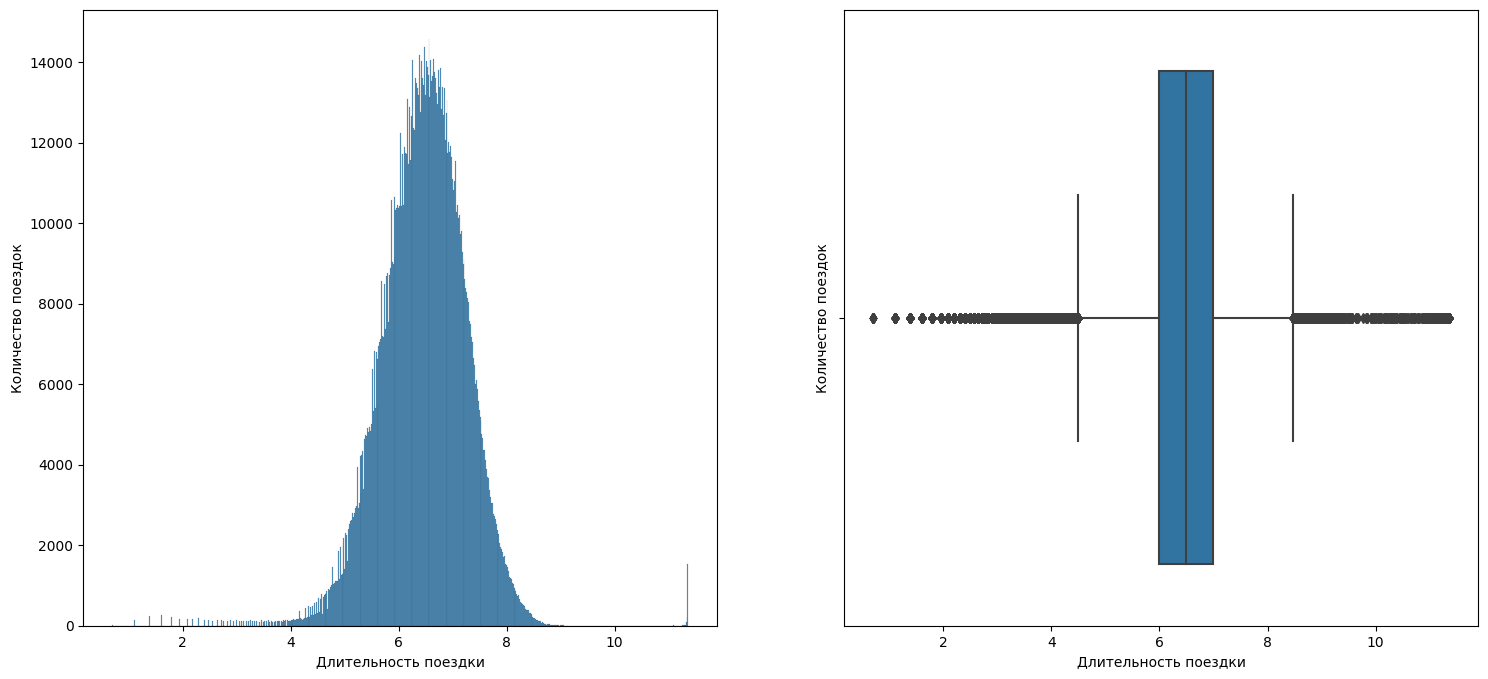

In [127]:
fig, axes = plt.subplots(1, 2, figsize = (18, 8))

hist = sns.histplot(data=taxi_df, x='trip_duration_log', ax=axes[0])
hist.set_xlabel('Длительность поездки')
hist.set_ylabel('Количество поездок')

box = sns.boxplot(data=taxi_df, x='trip_duration_log', ax=axes[1])
box.set_xlabel('Длительность поездки')
box.set_ylabel('Количество поездок')

fig.show()

По диаграмме видно присутствие множества выбросов, что говорит о ненормальном распределении. Проведем статистический тест, чтобы удостовериться в этой гипотезе, уровень значимости возьмем 0.05

In [128]:
from scipy import stats

p_value = stats.normaltest(taxi_df['trip_duration_log'])[1]

if p_value < 0.05:
    print("Признак распределен не по нормальному закону")
else:
    print("Признак распределен по нормальному закону")

Признак распределен не по нормальному закону


Статистический тест показал верность нашего предположения.

Посмотрим, зависит ли длительность поездки (trip_duration_log) от признаков:
  * таксопарк (vendor_id)
  * признак отправки сообщения поставщику (store_and_fwd_flag)
  * количество пассажиров (passenger_count)
  * является ли день поездки праздником (pickup_holiday)
  * погодные условия (events)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

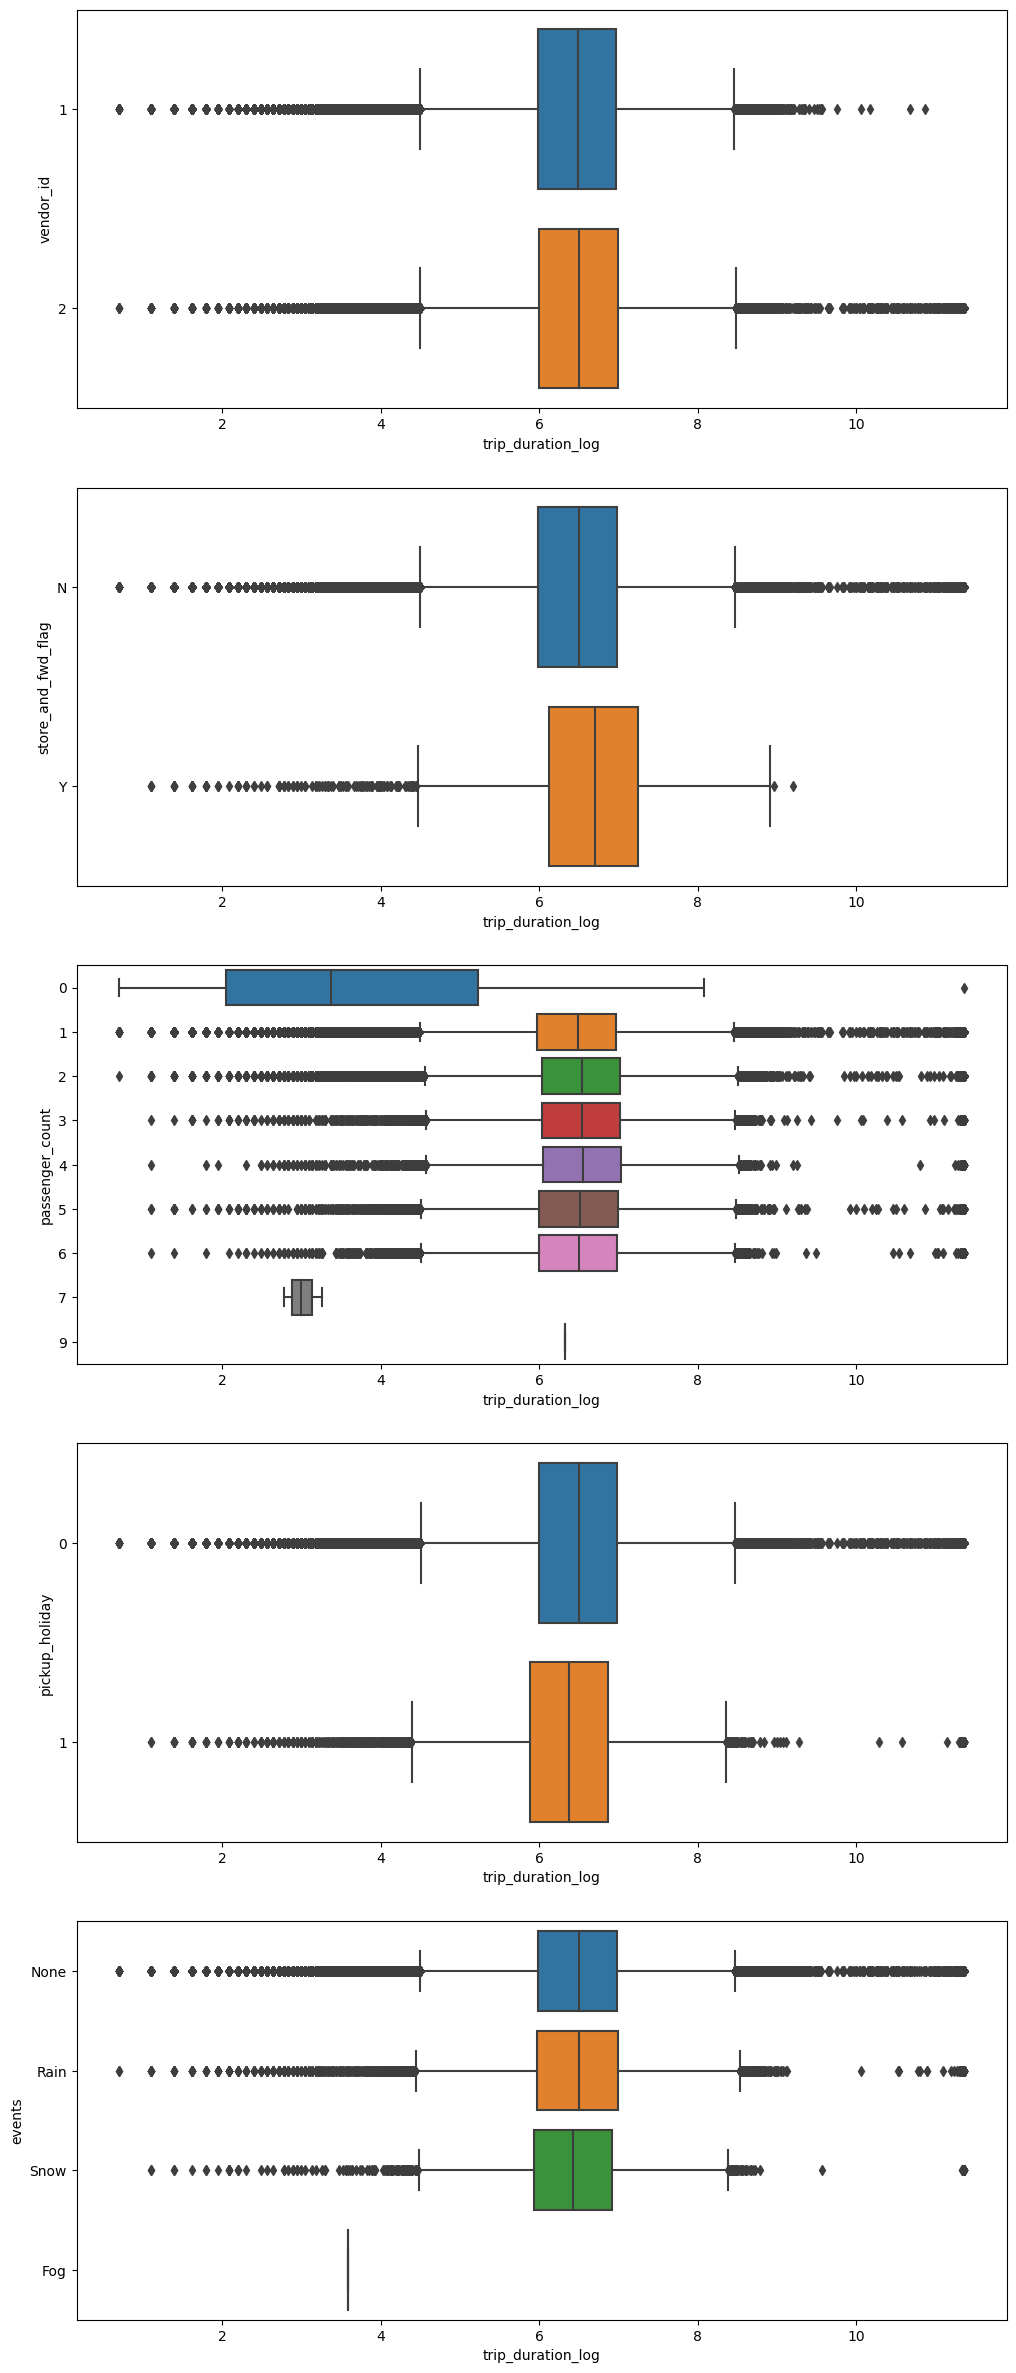

In [140]:
fig, axes = plt.subplots(5, 1, figsize = (12, 30))
i = 0

for feature in ['vendor_id', 'store_and_fwd_flag', 'passenger_count', 'pickup_holiday', 'events']:
    sns.boxplot(data=taxi_df, x='trip_duration_log', y=feature, orient='h', ax=axes[i])
    i+=1

Теперь построим две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

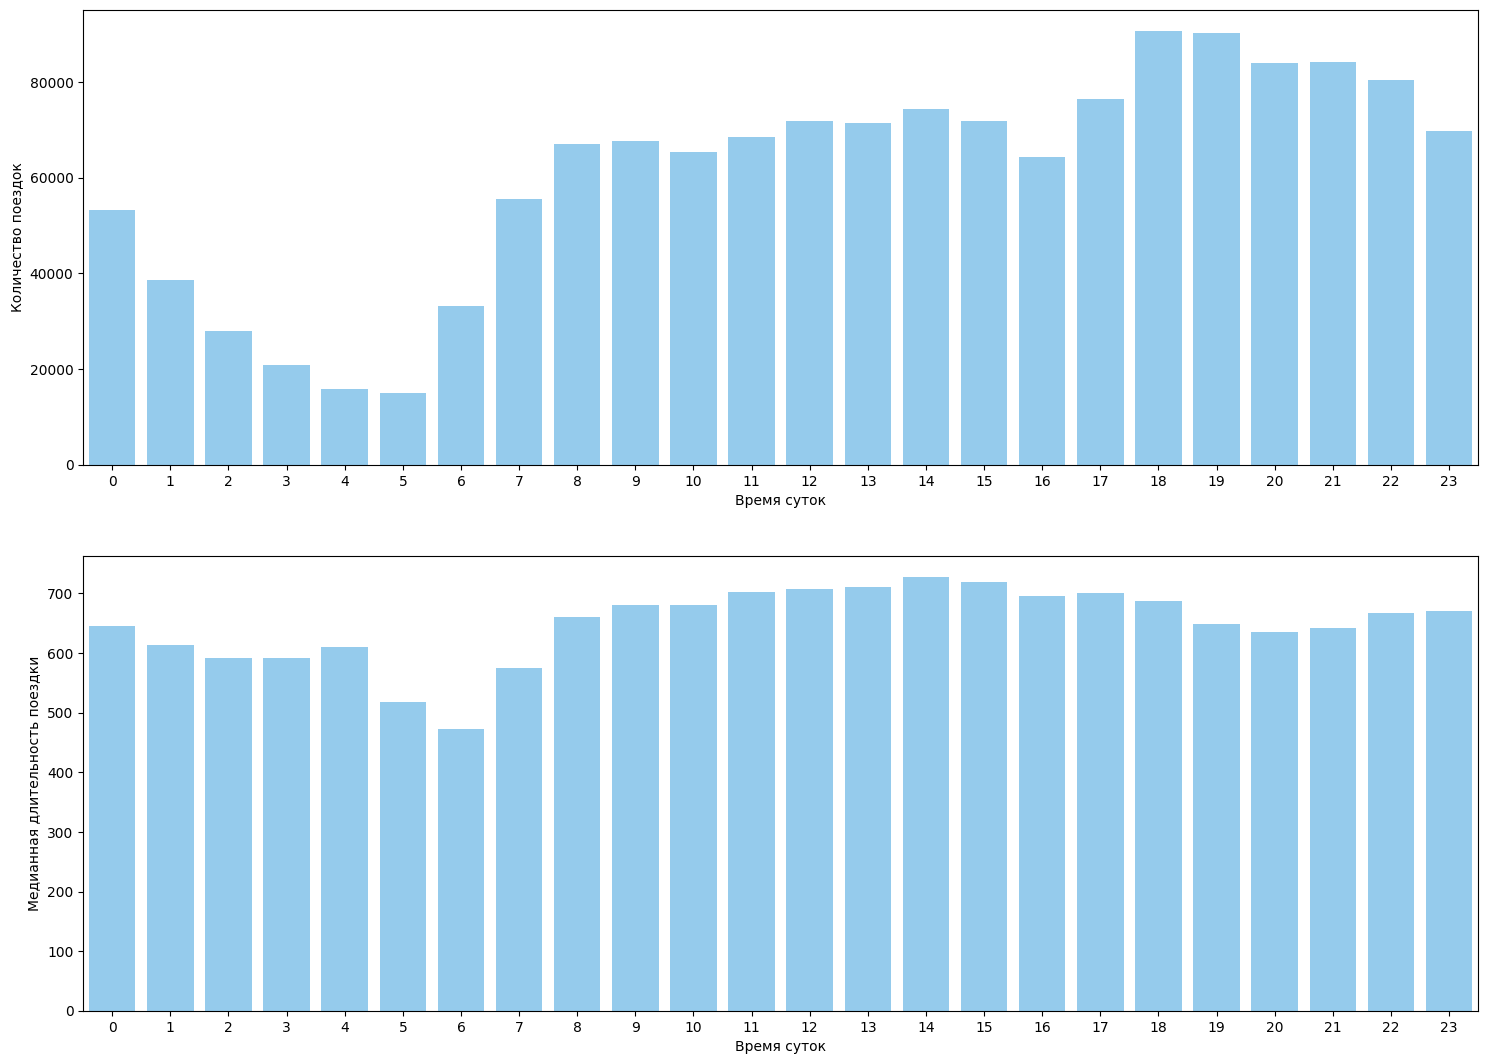

In [22]:
grouped = taxi_df.groupby('pickup_hour')['trip_duration'].median()

fig, axes = plt.subplots(2, 1, figsize = (18, 13))
countplot = sns.countplot(x=taxi_df['pickup_hour'], ax=axes[0], color='lightskyblue')
countplot.set_xlabel('Время суток')
countplot.set_ylabel('Количество поездок')
barplot = sns.barplot(x=grouped.index, y=grouped.values, ax=axes[1], color='lightskyblue')
barplot.set_xlabel('Время суток')
barplot.set_ylabel('Медианная длительность поездки')
fig.show()

Мы видим, что пик количества поездок 18-19 часов - время когда заканчивается рабочий день, минимум поездок в ночное время. А самые длинные поездки наблюдаются в середине дня (13-15 часов)

Построим еще две визуализации:
* Распределение количества поездок в зависимости от дня недели;
* Зависимость медианной длительности поездки от дня недели.

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

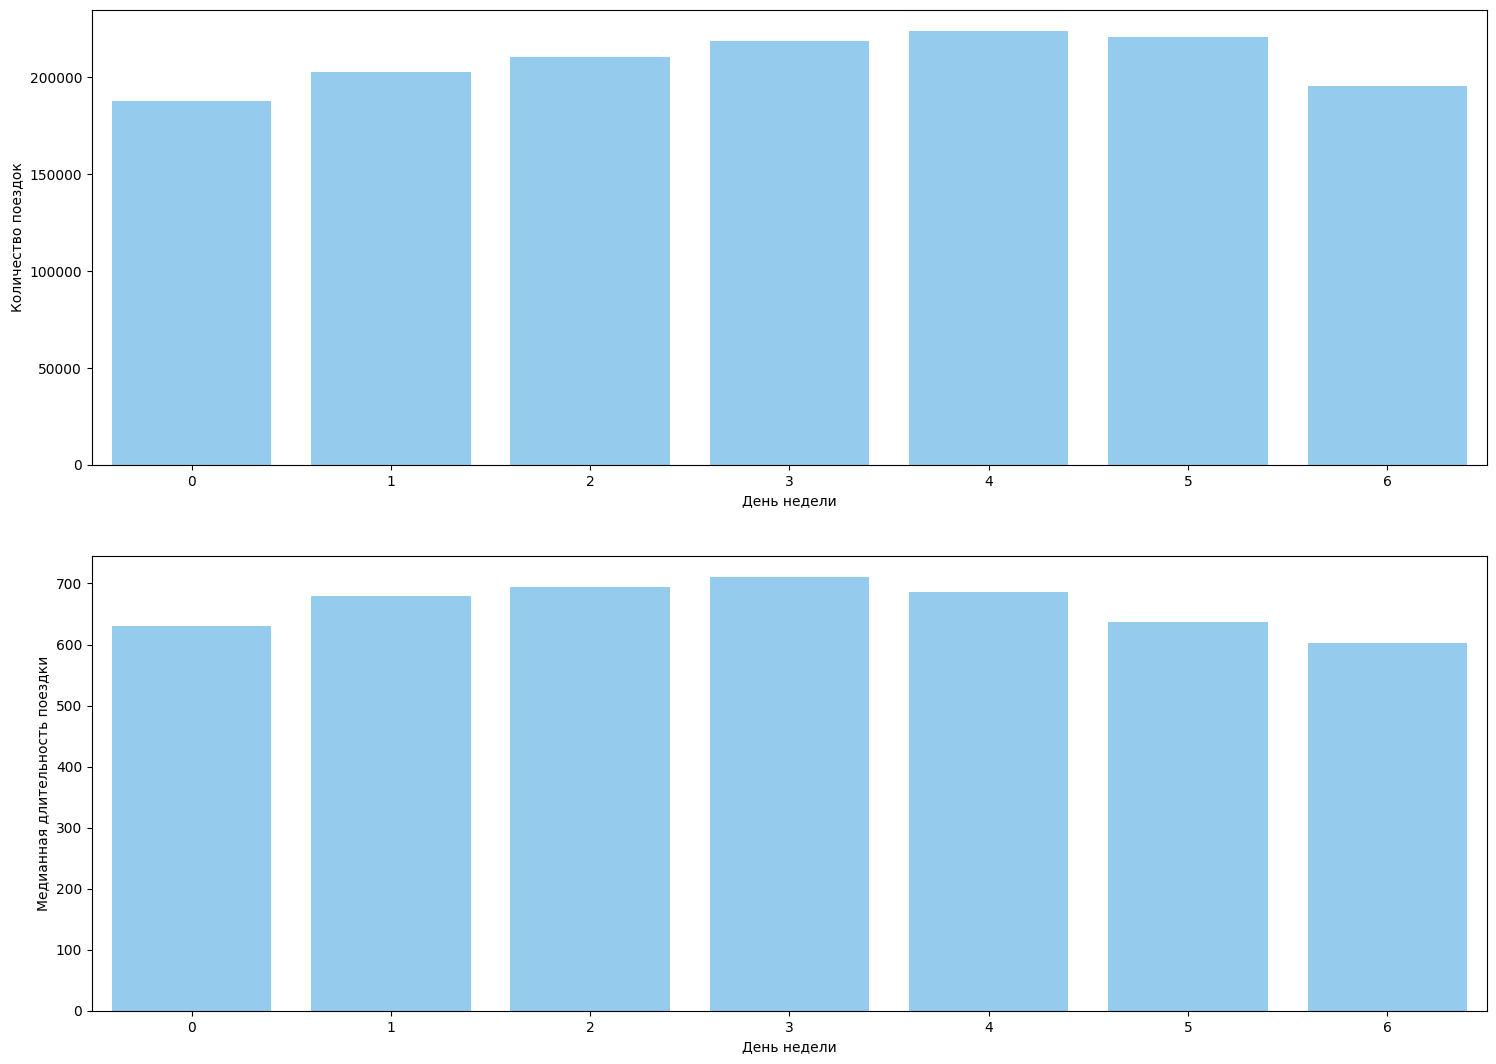

In [23]:
grouped = taxi_df.groupby('pickup_day_of_week')['trip_duration'].median()

fig, axes = plt.subplots(2, 1, figsize = (18, 13))
countplot = sns.countplot(x=taxi_df['pickup_day_of_week'], ax=axes[0], color='lightskyblue')
countplot.set_xlabel('День недели')
countplot.set_ylabel('Количество поездок')
barplot = sns.barplot(x=grouped.index, y=grouped.values, ax=axes[1], color='lightskyblue')
barplot.set_xlabel('День недели')
barplot.set_ylabel('Медианная длительность поездки')
fig.show()

Больше всего поездок в пятницу, а наиболее длительные поездки происходят по четвергам.

Посмотрим на обе временные характеристики одновременно. 

Построим сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

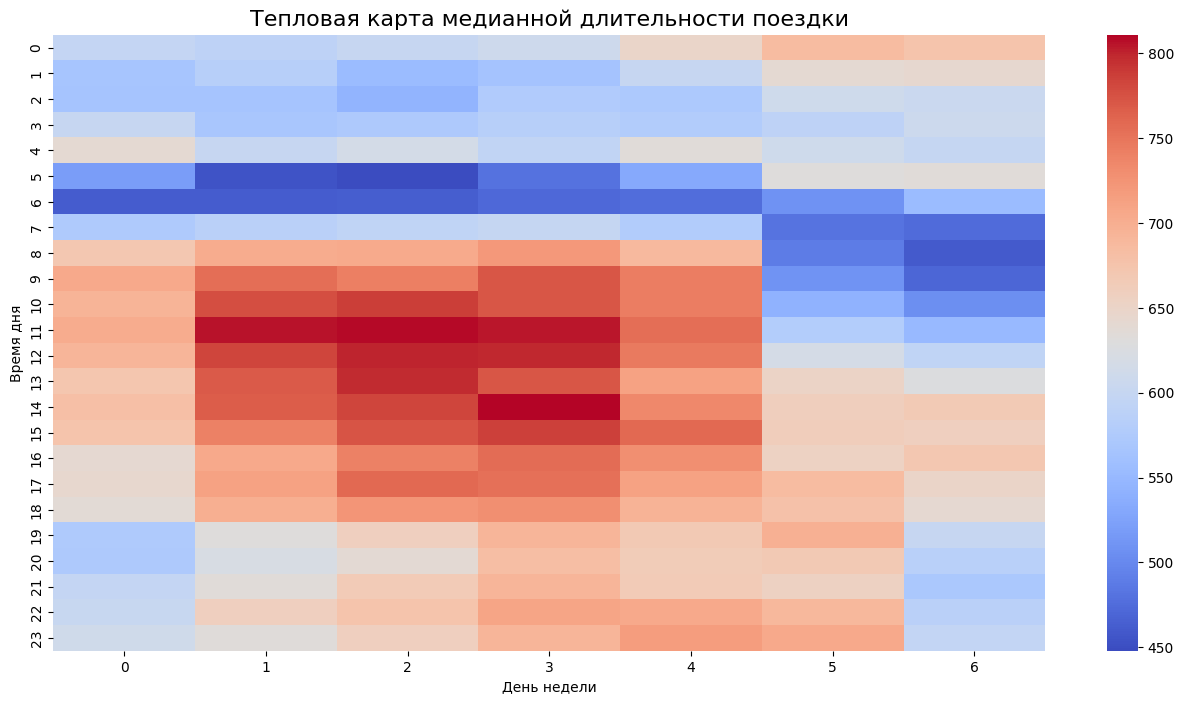

In [24]:
# Создаем сводную таблицу
pivot = taxi_df.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    aggfunc='median'
)

# Строим координатную плоскость
fig = plt.figure(figsize=(16, 8))

# Строим тепловую карту
heatmap = sns.heatmap(data=pivot, cmap='coolwarm')
heatmap.set_title('Тепловая карта медианной длительности поездки', fontsize=16)
heatmap.set_xlabel('День недели')
heatmap.set_ylabel('Время дня')
plt.show();

Мы видим, что наиболее длительные поездки происходят по будним дням (в основном вт-чт) и в дневное время (10-15 ч)

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов:
* Закодировать категориальные признаки;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.

In [143]:
print(f'Shape of data: {taxi_df.shape}')
print(f'Columns: {taxi_df.columns}')

Shape of data: (1457437, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [144]:
train_data = taxi_df.copy()
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,0,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,6,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,6,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,6,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,0,9.4,16.1,9.3,0.0,None,6.077642


Мы сразу можем избавиться от нескольких признаков: 
  * 'pickup_datetime' и 'dropoff_datetime', так как если мы их оставим, то произойдет утечка данных;
  * 'id' - абсолютно неинформативный признак;
  * 'pickup_date', с этого признака мы уже взяли всю нужную нам информацию.

In [145]:
train_data = train_data.drop(['id', 'pickup_datetime', 'dropoff_datetime', 'pickup_date'], axis=1)
print(f'Shape of data: {taxi_df.shape}')

Shape of data: (1457437, 27)


Закодируем бинарные признаки vendor_id и store_and_fwd_flag:

In [146]:
train_data['vendor_id'] = train_data['vendor_id'].apply(lambda x: 0 if x==1 else 1)
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].apply(lambda x: 0 if x=='N' else 1)

Теперь закодируем оставшиеся категориальные признаки методом однократного кодирования:

In [147]:
print(f'Размер датасета до преобразования: {train_data.shape}')
train_data = pd.get_dummies(train_data, columns=['pickup_day_of_week', 'geo_cluster', 'events'])
print(f'Размер датасета после преобразования: {train_data.shape}')

Размер датасета до преобразования: (1457437, 23)
Размер датасета после преобразования: (1457437, 41)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [148]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log. 

Разобьем выборку на обучающую и валидационную в соотношении 67/33 методом hold-out:

In [149]:
from sklearn import model_selection

X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберем 25 наиболее важных признаков:

In [39]:
from sklearn.feature_selection import SelectKBest, f_regression

# Создадим селектор и обучим его
selector = SelectKBest(score_func=f_regression, k=25)
selector.fit(X, y)

# Выведем лучшие признаки 
best = selector.get_feature_names_out()
best

array(['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'pickup_hour', 'pickup_holiday', 'total_distance',
       'total_travel_time', 'number_of_steps', 'haversine_distance',
       'temperature', 'pickup_day_of_week_0', 'pickup_day_of_week_3',
       'pickup_day_of_week_4', 'pickup_day_of_week_5',
       'pickup_day_of_week_6', 'geo_cluster_0', 'geo_cluster_1',
       'geo_cluster_4', 'geo_cluster_5', 'geo_cluster_6', 'geo_cluster_7',
       'geo_cluster_8'], dtype=object)

In [150]:
# Преобразуем выборки
X_train, X_valid = X_train[best], X_valid[best]

Теперь следует позаботиться о масштабировании признаков.

Нормализуем выборки при помощи MinMaxScaler:

In [152]:
from sklearn import preprocessing

# Сохраним названия колонок
cols = X_train.columns

# Создадим объект класса MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# Проведем нормализацию
X_train = pd.DataFrame(mm_scaler.fit_transform(X_train), columns=cols)
X_valid = pd.DataFrame(mm_scaler.transform(X_valid), columns=cols)

## 5. Решение задачи регрессии: линейная регрессия и деревья решений

В качестве метрики в данной работе рекомендуется использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 



Построим модель линейной регрессии с гиперпараметрами по умолчанию. Для полученной модели рассчитаем метрику RMSLE на тренировочной и валидационной выборках:

In [153]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

lr = linear_model.LinearRegression()
lr.fit(X_train, y_train_log)

y_pred_tr = lr.predict(X_train)
y_pred_val = lr.predict(X_valid)

print(f'Train: {np.round(np.sqrt(mean_squared_error(y_train_log, y_pred_tr)), 4)}')
print(f'Valid: {np.round(np.sqrt(mean_squared_error(y_valid_log, y_pred_val)), 4)}')

Train: 0.529
Valid: 0.5292


Теперь сгенерируем полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn, затем построим модель полиномиальной регрессии на полученных признаках. Чтобы модель не переобучилась, будем использовать L2-регуляцию, параметы оставим по умолчанию. 

In [155]:
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

X_train_poly = poly.fit_transform(X_train)
X_valid_poly = poly.fit_transform(X_valid)

ridge_lr = linear_model.Ridge()
ridge_lr.fit(X_train_poly, y_train_log)

y_pred_tr = ridge_lr.predict(X_train_poly)
y_pred_val = ridge_lr.predict(X_valid_poly)

print(f'Train: {np.round(np.sqrt(mean_squared_error(y_train_log, y_pred_tr)), 4)}')
print(f'Valid: {np.round(np.sqrt(mean_squared_error(y_valid_log, y_pred_val)), 4)}')

Train: 0.4678
Valid: 0.4678


Нам удалось уменьшить ошибку благодаря усложнению модели.

Теперь построим модель решающего дерева. Чтобы избежать переобучения, нам следует ограничить глубину дерева. А для того, чтобы подобрать оптимальную глубину, создадим цикл, в котором проидемся по разным значениям глубины, запишем величину ошибки для каждого значения. Затем визуализируем результат и подберем оптимальную глубину.

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future

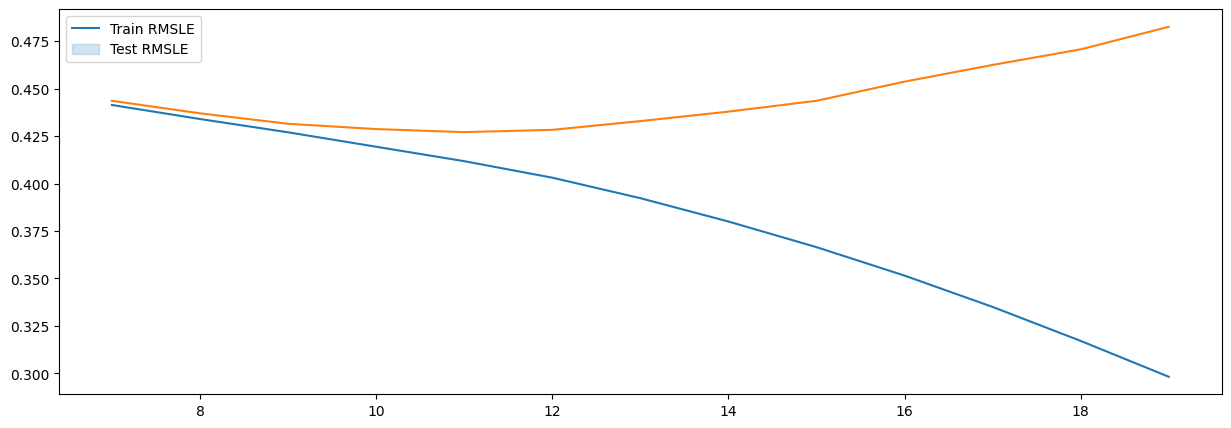

In [157]:
from sklearn import tree

# Создадим словари, в которых ключами будет глубина дерева, а значениями - ошибка модели
train_rmsle = {}
valid_rmsle = {}

# Создадим цикл, в котором будем изменять глубину дерева, остальные параметры - по умолчанию
for i in range(7, 20):
    dt = tree.DecisionTreeRegressor(max_depth=i)
    dt.fit(X_train, y_train_log)
    y_pred_tr = dt.predict(X_train)
    y_pred_val = dt.predict(X_valid)
    
    train_rmsle[i] = np.round(np.sqrt(mean_squared_error(y_train_log, y_pred_tr)), 4)
    valid_rmsle[i] = np.round(np.sqrt(mean_squared_error(y_valid_log, y_pred_val)), 4)

# Приведем словари к типу Series
train_rmsle = pd.Series(train_rmsle)
valid_rmsle = pd.Series(valid_rmsle)

# Визуализируем зависимость
fig = plt.figure(figsize=(15, 5))
sns.lineplot(x=train_rmsle.index, y=train_rmsle.values)
sns.lineplot(x=valid_rmsle.index, y=valid_rmsle.values)
plt.legend (('Train RMSLE', 'Test RMSLE'))

По графику видно, что наиболее оптимальной глубиной дерева является 11, в таком случае ошибка на валидационной выборке находится около минимума и расхождение с ошибкой на тренировочной выборке еще не такое большое.

In [159]:
print(f'Train: {train_rmsle[11]}')
print(f'Valid: {valid_rmsle[11]}')

Train: 0.4118
Valid: 0.4271


Решающее дерево смогло улучшить результат по сравнению с линейной и полиномиальной регрессиями.

## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Теперь попробуем применить ансамблевые алгоритмы. Так как деревья хорошо себя проявили, то попробуем построить ансамбли, основанные на деревьях. 

Построим модель случайного леса, глубину дерева возьмем 11, критерий выставим 'squared_error'.

In [160]:
from sklearn import ensemble

rf = ensemble.RandomForestRegressor(max_depth=11, criterion='squared_error')
rf.fit(X_train, y_train_log)

y_pred_tr = rf.predict(X_train)
y_pred_val = rf.predict(X_valid)

print(f'Train: {np.round(np.sqrt(mean_squared_error(y_train_log, y_pred_tr)), 4)}')
print(f'Valid: {np.round(np.sqrt(mean_squared_error(y_valid_log, y_pred_val)), 4)}')

Train: 0.403
Valid: 0.4154


Мы смогли еще немного улучшить результат.

Теперь построим модель градиентного бустинга над деревьями решений. Так как нам нужны более слабые отдельные модели деревьев, то следует ограничить их сильнее, чем в случайном лесу, поэтому выставим следующие параметры:
* learning_rate=0.5,
* max_depth=6, 
* min_samples_split=30

In [161]:
gb = ensemble.GradientBoostingRegressor(learning_rate=0.5,
                                        max_depth=6,
                                        min_samples_split=30
                                        )
gb.fit(X_train, y_train_log)

y_pred_tr = gb.predict(X_train)
y_pred_val = gb.predict(X_valid)

print(f'Train: {np.round(np.sqrt(mean_squared_error(y_train_log, y_pred_tr)), 4)}')
print(f'Valid: {np.round(np.sqrt(mean_squared_error(y_valid_log, y_pred_val)), 4)}')

Train: 0.3698
Valid: 0.3903


Из всех моделей градиентный бустинг показал наилучший результат. Мы можем посмотреть, какие признаки являются наиболее значимыми для предсказания целевой переменной. Построим график, демонстрирующий это:

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<AxesSubplot: >

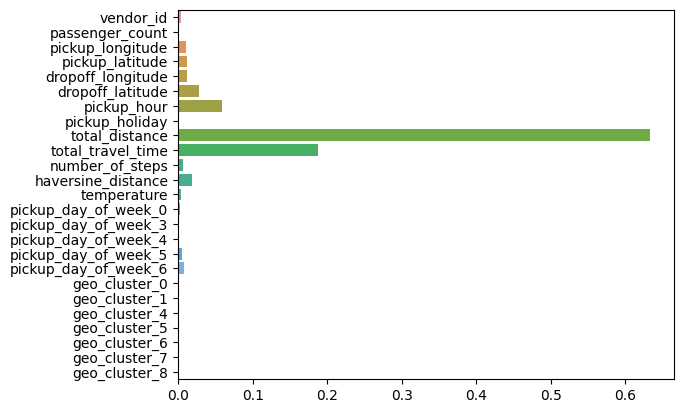

In [162]:
sns.barplot(x=gb.feature_importances_, y=X_train.columns)

Приступим к финальному шагу - предсказание на тестовом наборе данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [94]:
test_data = pd.read_csv('data/test.zip', compression='zip')
osrm_data_test = pd.read_csv('data/osrm_data_test.zip', compression='zip')
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой.

In [95]:
# Расширяем датасет
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_df)
test_data = add_orsm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data(test_data)

# Кодируем признаки
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data = pd.get_dummies(test_data, columns=['pickup_day_of_week', 'geo_cluster', 'events'])

# Выделяем значимые признаки и нормализуем
X_test = test_data[best]
X_test_scaled = mm_scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


После выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудем перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

Затем создадим submission файл, который отправим на kaggle.

In [98]:
y_test_pred = gb.predict(X_test)
y_test_pred = np.exp(y_test_pred) - 1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_pred})
submission.to_csv('data/submission_gb.csv', index=False)